# **AhR agonist AC10 value prediction_refine the model**





1.   Our goal is to build machine-learning based QSAR models to predict AhR agonists from their molecular structure.
2.   The models need to determine if a chemical is an AhR agonist or not and yield estimate for its EC10 value.

3.   The training dataset was updated by revising EC10 values using the confirmed bioaasay and adding more confirmed PAHs

In [ ]:
# Set up working directory
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# to restrict the float value to 3 dcimal places
pd.set_option('display.float_format',lambda x:'%.3f'%x)
import warnings
warnings.filterwarnings('ignore')

# **XGBRegressor trainning**

In [ ]:
# Installing the xgboost library using the 'pip' command
!pip install xgboost
# Importing XGBoost Regressor
from xgboost import XGBRegressor

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# To build models for prediction
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor

# For tuning the model
from sklearn.model_selection import GridSearchCV

# To check model performance
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

## **Split the trainning dataset as trinning data pool and test data pool**

In [ ]:
df_scal_fil = pd.read_csv('/content/Tranining_data_for_regression_prediction_scaled.csv', index_col=0)
ihm_scal_fil = pd.read_csv('/content/In_house_data_for_regression_scaled_high_specificity.csv', index_col=0)
df_val = pd.read_csv('/content/Confirm_structure_scaled.csv', index_col=0)

In [ ]:
# Separating the target variable and other variables
X = df_scal_fil.drop(columns = ['AC_10'])
Y = df_scal_fil['AC_10']

X_eval = ihm_scal_fil.drop(columns = ['AC_10'])
Y_eval = ihm_scal_fil['AC_10']

X_val = df_val.drop(columns = ['AC_10'])
Y_val = df_val['AC_10']

In [ ]:
X.shape, Y.shape

((241, 529), (241,))

In [ ]:
X_eval.shape, Y_eval.shape

((10, 529), (10,))

In [ ]:
X_val.shape, Y_val.shape

((12, 529), (12,))

In [ ]:
# Separating the target variable and other variables
X_combine = pd.concat([X, X_val], ignore_index=False)
Y_combine = pd.concat([Y, Y_val], ignore_index=False)

In [ ]:
# Splitting the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X_combine, Y_combine, test_size = 0.2, random_state = 5897, shuffle=True, stratify = None)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((202, 529), (51, 529), (202,), (51,))




**1.   As the size of trainning dataset for regression model is limited, the stratify method can not be used in the train_test_split.**

**2.   After tunning, test_size with 20% performed the best until now.**



In [ ]:
# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    pred = model.predict(predictors)                   # Predict using the independent variables
    r2 = r2_score(target, pred)                     # To compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)           # To compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))           # To compute RMSE
    mae = mean_absolute_error(target, pred)               # To compute MAE
    mape = mean_absolute_percentage_error(target, pred)         # To compute MAPE

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

## **Training**

In [ ]:
# Setup parameters, without PCB 138
xgb = XGBRegressor (
           booster = "gbtree",
           tree_method= "hist",
           device = 'cuda',
           sampling_method = 'gradient_based',
           colsample_bylevel= 0.8,
           colsample_bytree= 0.8,
           colsample_bynode= 0.8,
           subsample = 0.4,
           n_estimators = 200,
           max_depth = 8,
           min_child_weight = 6,
           base_score = 0.8,
           num_parallel_tree = 12,
           gamma = 0.1,
           eta = 0.08,
           early_stopping_rounds = 8,
           eval_metric= "rmse",
           reg_alpha = 0.1,       # L1 regularization
           reg_lambda = 1,        # L2 regularization
           random_state = 234)

# Fitting the model
xgb.fit(x_train,y_train, eval_set=[(x_test, y_test)])

#xgb.fit(x_train,y_train, eval_set=[(X_eval, Y_eval)])

[0]	validation_0-rmse:0.67018
[1]	validation_0-rmse:0.64204
[2]	validation_0-rmse:0.61876
[3]	validation_0-rmse:0.59889
[4]	validation_0-rmse:0.58339
[5]	validation_0-rmse:0.57291
[6]	validation_0-rmse:0.56069
[7]	validation_0-rmse:0.55133
[8]	validation_0-rmse:0.53796
[9]	validation_0-rmse:0.52883
[10]	validation_0-rmse:0.51852
[11]	validation_0-rmse:0.51265
[12]	validation_0-rmse:0.50990
[13]	validation_0-rmse:0.50584
[14]	validation_0-rmse:0.50140
[15]	validation_0-rmse:0.49898
[16]	validation_0-rmse:0.49441
[17]	validation_0-rmse:0.49476
[18]	validation_0-rmse:0.49009
[19]	validation_0-rmse:0.48743
[20]	validation_0-rmse:0.48486
[21]	validation_0-rmse:0.48189
[22]	validation_0-rmse:0.48075
[23]	validation_0-rmse:0.47903
[24]	validation_0-rmse:0.47891
[25]	validation_0-rmse:0.47670
[26]	validation_0-rmse:0.47544
[27]	validation_0-rmse:0.47730
[28]	validation_0-rmse:0.47647
[29]	validation_0-rmse:0.47702
[30]	validation_0-rmse:0.47467
[31]	validation_0-rmse:0.47517
[32]	validation_0-

XGBRegressor(base_score=0.8, booster='gbtree', callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=0.8, colsample_bytree=0.8,
             device='cuda', early_stopping_rounds=8, enable_categorical=False,
             eta=0.08, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, ...)

In [ ]:
# Model Performance on the trainning data
xgb_train = model_performance_regression(xgb, x_train, y_train)
xgb_train

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.117,0.090,0.974,1.016,0.204


In [ ]:
# Model Performance on the test data
xgb_test = model_performance_regression(xgb, x_test, y_test)
xgb_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.458,0.349,0.515,1.051,0.961


In [ ]:
# Model Performance on the all training data
xgb_all = model_performance_regression(xgb, X_combine, Y_combine)
xgb_all

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.231,0.143,0.895,1.095,0.356


In [ ]:
# Model Performance on the all training data
xgb_eval = model_performance_regression(xgb, X_eval, Y_eval)
xgb_eval

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.712,0.582,0.046,1.017,2.794


In [ ]:
#Predict
xgb_predict_train = xgb.predict(x_train)
Results_trainning = pd.DataFrame(xgb_predict_train, columns = ['Prediction_train'])
Results_trainning["Observation_train"] = pd.DataFrame(y_train.values)
Results_trainning.index = x_train.index

xgb_predict_test = xgb.predict(x_test)
Results_test = pd.DataFrame(xgb_predict_test, columns = ['Prediction_test'])
Results_test["Observation_test"] = pd.DataFrame(y_test.values)
Results_test.index = x_test.index

xgb_predict_all = xgb.predict(X_combine)
Results_all = pd.DataFrame(xgb_predict_all, columns = ['Prediction_all'])
Results_all["Observation_all"] = pd.DataFrame(Y_combine.values)
Results_all.index = X_combine.index


xgb_predict_eval = xgb.predict(X_eval)
Results_eval = pd.DataFrame(xgb_predict_eval, columns = ['Prediction_eval'])
Results_eval["Observation_eval"] = pd.DataFrame(Y_eval.values)
Results_eval.index = X_eval.index

In [ ]:
Results_all.to_csv('Prediction_for_training_data_regression.csv', index = True)

In [ ]:
Results_eval.to_csv('Prediction_for_in-house_dataset_regression.csv', index = True)

[(-5.0, 5.0)]

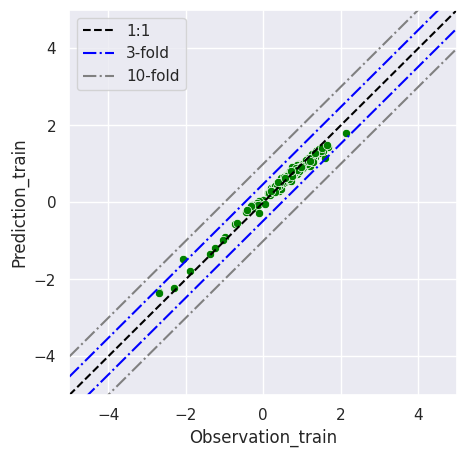

In [ ]:
#plot
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=Results_trainning, x='Observation_train', y='Prediction_train', color='green')
# Draw a diagonal line
ax.plot([-5, 5], [-5, 5], ls='--', color='black', label='1:1')

# Draw 2-fold line
#x_vals = [-1, 2]
#y_vals_plus = [x + 0.3 for x in x_vals]
#ax.plot(x_vals, y_vals_plus, ls='-.', color='blue', label='2-fold')

# Draw 2-fold line
#y_vals_minus = [x - 0.3 for x in x_vals]
#ax.plot(x_vals, y_vals_minus, ls='-.', color='blue')


# Draw 3-fold line
x_vals = [-5, 5]
y_vals_plus = [x + 0.477 for x in x_vals]
ax.plot(x_vals, y_vals_plus, ls='-.', color='blue', label='3-fold')

# Draw 3-fold line
y_vals_minus = [x - 0.477 for x in x_vals]
ax.plot(x_vals, y_vals_minus, ls='-.', color='blue')

# Draw 10-fold line
x_vals = [-5, 5]
y_vals_plus = [x + 1 for x in x_vals]
ax.plot(x_vals, y_vals_plus, ls='-.', color='grey', label='10-fold')

# Draw 10-fold line
y_vals_minus = [x - 1 for x in x_vals]
ax.plot(x_vals, y_vals_minus, ls='-.', color='grey')
ax.legend()

# Add legend for all lines
ax.legend()

ax.set(xlim=(-5, 5))
ax.set(ylim=(-5, 5))

[(-4.0, 4.0)]

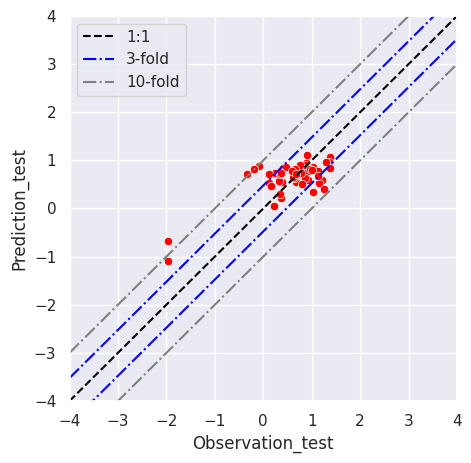

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=Results_test, x='Observation_test', y='Prediction_test',color='red')
# Draw a diagonal line
ax.plot([-4, 4], [-4, 4], ls='--', color='black', label='1:1')

# Draw 2-fold line
#x_vals = [-1, 2]
#y_vals_plus = [x + 0.3 for x in x_vals]
#ax.plot(x_vals, y_vals_plus, ls='-.', color='blue', label='2-fold line')

# Draw 2-fold line
#y_vals_minus = [x - 0.3 for x in x_vals]
#ax.plot(x_vals, y_vals_minus, ls='-.', color='blue')

# Draw 3-fold line
x_vals = [-4, 4]
y_vals_plus = [x + 0.477 for x in x_vals]
ax.plot(x_vals, y_vals_plus, ls='-.', color='blue', label='3-fold')

# Draw 3-fold line
y_vals_minus = [x - 0.477 for x in x_vals]
ax.plot(x_vals, y_vals_minus, ls='-.', color='blue')
ax.legend()

# Draw 10-fold line
x_vals = [-4, 4]
y_vals_plus = [x + 1 for x in x_vals]
ax.plot(x_vals, y_vals_plus, ls='-.', color='grey', label='10-fold')

# Draw 10-fold line
y_vals_minus = [x - 1 for x in x_vals]
ax.plot(x_vals, y_vals_minus, ls='-.', color='grey')
ax.legend()


ax.set(xlim=(-4, 4))
ax.set(ylim=(-4, 4))

[(-4.0, 4.0)]

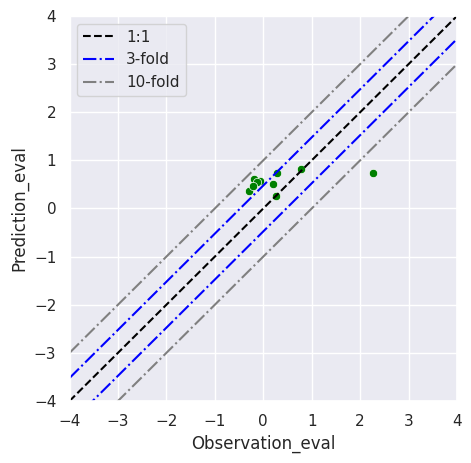

In [ ]:
#plot
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=Results_eval, x='Observation_eval', y='Prediction_eval', color='green')
# Draw a diagonal line
ax.plot([-4, 4], [-4, 4], ls='--', color='black', label='1:1')

# Draw 2-fold line
#x_vals = [-1, 2]
#y_vals_plus = [x + 0.3 for x in x_vals]
#ax.plot(x_vals, y_vals_plus, ls='-.', color='blue', label='2-fold')

# Draw 2-fold line
#y_vals_minus = [x - 0.3 for x in x_vals]
#ax.plot(x_vals, y_vals_minus, ls='-.', color='blue')


# Draw 3-fold line
x_vals = [-4, 4]
y_vals_plus = [x + 0.477 for x in x_vals]
ax.plot(x_vals, y_vals_plus, ls='-.', color='blue', label='3-fold')

# Draw 3-fold line
y_vals_minus = [x - 0.477 for x in x_vals]
ax.plot(x_vals, y_vals_minus, ls='-.', color='blue')

# Draw 10-fold line
x_vals = [-4, 4]
y_vals_plus = [x + 1 for x in x_vals]
ax.plot(x_vals, y_vals_plus, ls='-.', color='grey', label='10-fold')

# Draw 10-fold line
y_vals_minus = [x - 1 for x in x_vals]
ax.plot(x_vals, y_vals_minus, ls='-.', color='grey')
ax.legend()

# Add legend for all lines
ax.legend()

ax.set(xlim=(-4, 4))
ax.set(ylim=(-4, 4))

[(-4.0, 4.0)]

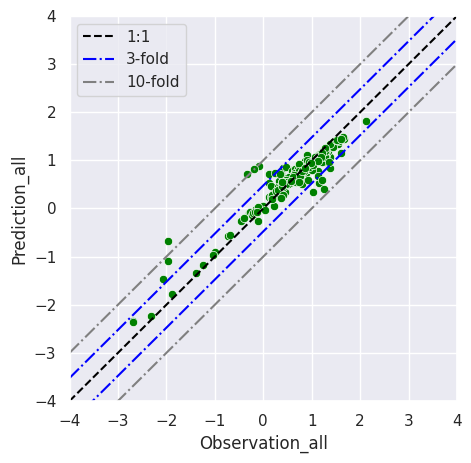

In [ ]:
#plot
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=Results_all, x='Observation_all', y='Prediction_all', color='green')
# Draw a diagonal line
ax.plot([-4, 4], [-4, 4], ls='--', color='black', label='1:1')

# Draw 2-fold line
#x_vals = [-1, 2]
#y_vals_plus = [x + 0.3 for x in x_vals]
#ax.plot(x_vals, y_vals_plus, ls='-.', color='blue', label='2-fold')

# Draw 2-fold line
#y_vals_minus = [x - 0.3 for x in x_vals]
#ax.plot(x_vals, y_vals_minus, ls='-.', color='blue')


# Draw 3-fold line
x_vals = [-4, 4]
y_vals_plus = [x + 0.477 for x in x_vals]
ax.plot(x_vals, y_vals_plus, ls='-.', color='blue', label='3-fold')

# Draw 3-fold line
y_vals_minus = [x - 0.477 for x in x_vals]
ax.plot(x_vals, y_vals_minus, ls='-.', color='blue')

# Draw 10-fold line
x_vals = [-4, 4]
y_vals_plus = [x + 1 for x in x_vals]
ax.plot(x_vals, y_vals_plus, ls='-.', color='grey', label='10-fold')

# Draw 10-fold line
y_vals_minus = [x - 1 for x in x_vals]
ax.plot(x_vals, y_vals_minus, ls='-.', color='grey')
ax.legend()

# Add legend for all lines
ax.legend()

ax.set(xlim=(-4, 4))
ax.set(ylim=(-4, 4))

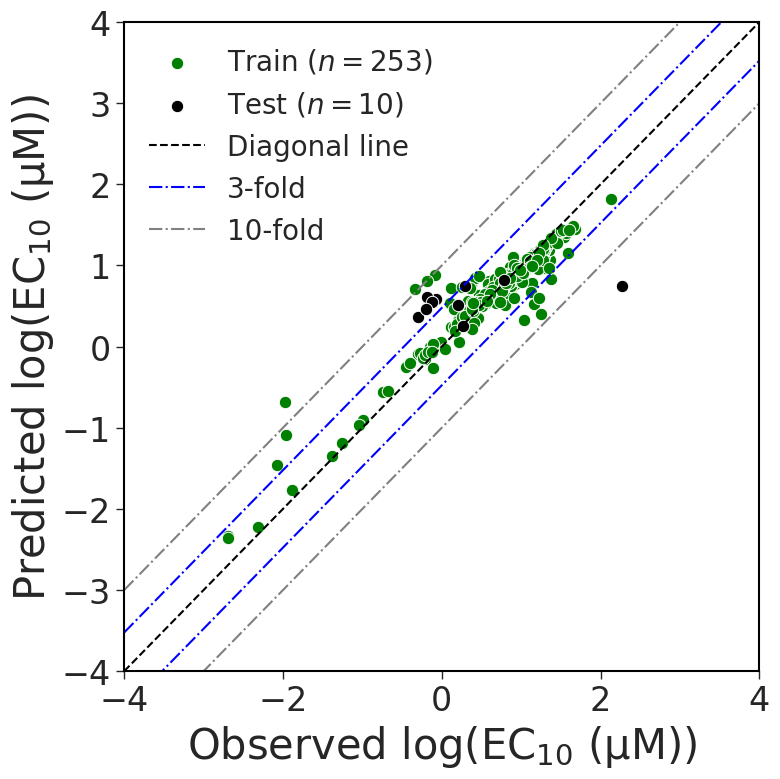

In [ ]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot training data
n = 253
sns.scatterplot(
    data=Results_all,
    x='Observation_all',
    y='Prediction_all',
    color='green',
    label=f'Train ($\\it{{n = {n}}}$)',
    **{'s': 80}  # pass s directly via kwargs
)

# Plot testing data
m = 10
sns.scatterplot(
    data=Results_eval,
    x='Observation_eval',
    y='Prediction_eval',
    color='black',
    label=f'Test ($\\it{{n = {m}}}$)',
    **{'s': 80}  # pass s directly via kwargs
)

# Draw the 1:1 diagonal line
ax.plot([-4, 4], [-4, 4], ls='--', color='black', label='Diagonal line')

# Draw 3-fold lines
x_vals = [-4, 4]
y_vals_plus_3 = [x + 0.477 for x in x_vals]
y_vals_minus_3 = [x - 0.477 for x in x_vals]
ax.plot(x_vals, y_vals_plus_3, ls='-.', color='blue', label='3-fold')
ax.plot(x_vals, y_vals_minus_3, ls='-.', color='blue')

# Draw 10-fold lines
y_vals_plus_10 = [x + 1 for x in x_vals]
y_vals_minus_10 = [x - 1 for x in x_vals]
ax.plot(x_vals, y_vals_plus_10, ls='-.', color='grey', label='10-fold')
ax.plot(x_vals, y_vals_minus_10, ls='-.', color='grey')

# Set axis limits
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)

# Customize tick parameters
ax.tick_params(direction='out', length=6, width=1, labelsize=24)

# Position axes spines
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Make spines visible and style them
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_edgecolor('black')

# Set background color
ax.set_facecolor('white')
ax.patch.set_facecolor('none')

# Add grid
plt.grid(True)

# Set axis labels with larger font size
ax.set_xlabel('Observed log(EC$_{10}$ (µM))', fontsize=30)
ax.set_ylabel('Predicted log(EC$_{10}$ (µM))', fontsize=30)

# Add legend with larger font size and no frame
ax.legend(fontsize=20, frameon=False)

# Adjust layout and save figure
plt.tight_layout(pad=1.2)
plt.savefig('Regression_performance.jpg', dpi=600)
plt.show()

In [ ]:
import joblib
from google.colab import files
joblib.dump(xgb, 'Regression_model_20251104.pkl')  # Save
# Download the file to your local machine
files.download('Regression_model_20251104.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **CrossValidation for 5 folds**

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=2423)
performance_results = []

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):

    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    xgb_cv = XGBRegressor (
           booster = "gbtree",
           tree_method= "gpu_hist",
           device = 'cuda',
           sampling_method = 'gradient_based',
           colsample_bylevel= 0.8,
           colsample_bytree= 0.8,
           colsample_bynode= 0.8,
           subsample = 0.4,
           n_estimators = 200,
           max_depth = 8,
           min_child_weight = 6,
           base_score = 0.8,
           num_parallel_tree = 12,
           gamma = 0.1,
           eta = 0.08,
           early_stopping_rounds = 8,
           eval_metric= "rmse",
           reg_alpha = 0.1,       # L1 regularization
           reg_lambda = 1,        # L2 regularization
           random_state = 234)

    xgb_cv.fit(x_train, y_train,
         eval_set=[(x_test, y_test)],
    )
    # Model Performance on the test data
    #result = model_performance_regression(xgb_cv, X_combine, Y_combine)
    result = model_performance_regression(xgb_cv, X_eval, Y_eval)
    result['fold'] = fold  # Add fold number for clarity
    performance_results.append(result)

[0]	validation_0-rmse:0.78857
[1]	validation_0-rmse:0.77479
[2]	validation_0-rmse:0.76085
[3]	validation_0-rmse:0.74623
[4]	validation_0-rmse:0.73582
[5]	validation_0-rmse:0.72601
[6]	validation_0-rmse:0.71616
[7]	validation_0-rmse:0.70553
[8]	validation_0-rmse:0.70161
[9]	validation_0-rmse:0.69287
[10]	validation_0-rmse:0.68595
[11]	validation_0-rmse:0.67924
[12]	validation_0-rmse:0.67038
[13]	validation_0-rmse:0.66242
[14]	validation_0-rmse:0.65582
[15]	validation_0-rmse:0.65083
[16]	validation_0-rmse:0.64976
[17]	validation_0-rmse:0.64460
[18]	validation_0-rmse:0.64029
[19]	validation_0-rmse:0.63443
[20]	validation_0-rmse:0.62984
[21]	validation_0-rmse:0.62282
[22]	validation_0-rmse:0.61768
[23]	validation_0-rmse:0.61255
[24]	validation_0-rmse:0.60925
[25]	validation_0-rmse:0.60902
[26]	validation_0-rmse:0.60623
[27]	validation_0-rmse:0.60382
[28]	validation_0-rmse:0.60104
[29]	validation_0-rmse:0.59603
[30]	validation_0-rmse:0.59411
[31]	validation_0-rmse:0.59032
[32]	validation_0-

In [ ]:
performance_df = pd.concat(performance_results, ignore_index=True)

In [ ]:
performance_df

,RMSE,MAE,R-squared,Adj. R-squared,MAPE,fold
0,0.681,0.570,0.126,1.015,2.514,1
1,0.716,0.612,0.034,1.017,2.767,2
2,0.671,0.532,0.151,1.015,2.426,3
3,0.729,0.642,-0.000,1.017,3.026,4
4,0.865,0.776,-0.408,1.024,3.877,5


In [ ]:
xgb_cv.fit(x_train,y_train, eval_set=[(x_test, y_test)])

[0]	validation_0-rmse:0.54013
[1]	validation_0-rmse:0.53796
[2]	validation_0-rmse:0.53943
[3]	validation_0-rmse:0.54506
[4]	validation_0-rmse:0.54858
[5]	validation_0-rmse:0.55064
[6]	validation_0-rmse:0.55428
[7]	validation_0-rmse:0.55926
[8]	validation_0-rmse:0.56380
[9]	validation_0-rmse:0.56867


XGBRegressor(base_score=0.8, booster='gbtree', callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=0.8, colsample_bytree=0.8,
             device='cuda', early_stopping_rounds=8, enable_categorical=False,
             eta=0.08, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, ...)

In [ ]:
# Model Performance on the test data
xgb_test_cv = model_performance_regression(xgb_cv, x_test, y_test)
xgb_test_cv

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.538,0.425,0.004,1.097,0.810


## **Hyperparameter tuning for XGB**

In [ ]:
# Setup parameters
xgb = XGBRegressor (
           booster = "gbtree",
           tree_method= "gpu_hist",
           device = 'cuda',
           sampling_method = 'gradient_based',
           colsample_bylevel= 0.95,
           colsample_bytree= 0.95,
           colsample_bynode= 0.95,
           subsample = 0.4,
           n_estimators = 100,
           max_depth = 8,
           min_child_weight = 10,
           base_score = 0.7,
           num_parallel_tree = 10,
           gamma = 1,
           eta = 0.05,
           early_stopping_rounds = 6,
           eval_metric= "rmse",
           random_state = 123)

In [ ]:
np.arange(6,20,3)

array([ 6,  9, 12, 15, 18])

In [ ]:
from sklearn.model_selection import RepeatedKFold
# Choose the type of classifier
xgb_tuned = XGBRegressor (
                           booster = "gbtree",
                           tree_method= "gpu_hist",
                           device = 'cuda',
                           sampling_method = 'gradient_based',
                           colsample_bylevel= 0.95,
                           colsample_bytree= 0.95,
                           colsample_bynode= 0.95,
                           #subsample = 0.7,
                           n_estimators = 100,
                           #max_depth = 18,
                           #min_child_weight = 20,
                           #base_score = 0.8,
                           #num_parallel_tree = 12,
                           gamma = 1,
                           eta = 0.05,
                           early_stopping_rounds = 6,
                           #eval_metric= "rmse",
                           random_state = 123)

# Grid of parameters to choose from
parameters = {"subsample": [0.3, 0.5, 0.7, 0.9],
             "max_depth": np.arange(6,20,3),
             'min_child_weight': np.arange(6,20,3),
             "base_score": np.arange(0.4,1,0.2),
             "num_parallel_tree": np.arange(6,20,3),
             }

# cross validation
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters, scoring = "neg_root_mean_squared_error", cv = cv, n_jobs = -1)

grid_obj = grid_obj.fit(x_train,y_train, eval_set=[(x_test, y_test)])

# Set the classifier to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_
grid_obj.best_params_

In [ ]:
# Fitting the model
xgb_tuned.fit(x_train,y_train, eval_set=[(x_test, y_test)])

In [ ]:
# Model Performance on the trainning data
xgb_tuned_train = model_performance_regression(xgb_tuned, x_train, y_train)
xgb_tuned_train

# **Prediction for candidates**

**Prediction for all candidates after library matching**

In [ ]:
#load dataset
df_all = pd.read_csv('/content/df_all_scaled.csv', index_col=0)

In [ ]:
df_all_prediction = xgb.predict(df_all)
df_all_prediction = pd.DataFrame(df_all_prediction, columns = ['Prediction'])
df_all_prediction.index = df_all.index

In [ ]:
df_all_prediction.to_csv('df_all_prediction.csv', index = True)

**Prediction for compounds in the target list**

In [ ]:
#load dataset
df_target = pd.read_csv('/content/df_target_scaled.csv', index_col=0)

In [ ]:
df_target_prediction = xgb.predict(df_target)
df_target_prediction = pd.DataFrame(df_target_prediction, columns = ['Prediction'])
df_target_prediction.index = df_target.index

In [ ]:
df_target_prediction.to_csv('df_target_prediction.csv', index = True)

In [ ]:
df=df_target_prediction.reset_index()

In [ ]:
df[df['index'] == '193-39-5']

,index,Prediction
185,193-39-5,-1.564
